In [1]:
# Author : Ravindra M <ravindra@utexas.edu>
import pandas as pd

In [2]:
train_df = pd.read_csv("train.tsv", sep='\t', header=0)
test_df = pd.read_csv("test.tsv", sep='\t', header=0)

In [3]:
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
test_df.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


## Text Preprocessing

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

In [6]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [7]:
#stopwords are high-frequency words like the, to and also that.
#We sometimes want to filter out of a document before further processing.
#Stopwords usually have little lexical content, and their presence in a text fails to distinguish it from other texts.

stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

In [8]:
print stop_words

set([u'all', u'just', u'being', u'over', u'both', u'through', u'yourselves', u'its', u'before', u'o', u'hadn', u'herself', u'll', u'had', ',', u'should', u'to', u'only', u'won', u'under', u'ours', u'has', u'do', u'them', u'his', u'very', u'they', u'not', u'during', u'now', u'him', u'nor', u'd', u'did', u'didn', u'this', u'she', u'each', u'further', u'where', u'few', u'because', u'doing', u'some', u'hasn', u'are', u'our', u'ourselves', u'out', u'what', u'for', u'while', u're', u'does', u'above', u'between', u'mustn', u't', u'be', u'we', u'who', u'were', u'here', u'shouldn', u'hers', '[', u'by', u'on', u'about', u'couldn', u'of', u'against', u's', u'isn', '(', '{', u'or', u'own', u'into', u'yourself', u'down', u'mightn', u'wasn', u'your', '"', u'from', u'her', u'their', u'aren', u'there', u'been', '.', u'whom', u'too', u'wouldn', u'themselves', u'weren', u'was', u'until', u'more', u'himself', u'that', u'but', ';', u'don', u'with', u'than', u'those', u'he', u'me', u'myself', ':', u'ma', u

In [9]:
# change walking -> walk
stemmer = SnowballStemmer('english')

In [10]:
# extract train and test sentences
train_sentences = train_df['Phrase'].values
test_sentences = test_df['Phrase'].values

In [11]:
print len(train_sentences), len(test_sentences)

156060 66292


In [12]:
print train_sentences[0]
print train_sentences[1]

A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .
A series of escapades demonstrating the adage that what is good for the goose


In [13]:
def sentence_to_word(sentences):
    processed_sentences = []
    for sentence in sentences:
        # break up sentence into words
        words = word_tokenize(sentence)
        # remove stop words from sentence
        filtered = [word for word in words if word not in stop_words]
        # remove stemming from words example: liking -> like
        stemmed = [stemmer.stem(word) for word in filtered]
        processed_sentences.append(stemmed)
    return processed_sentences

In [14]:
processed_sentences_train = sentence_to_word(train_sentences)
processed_sentences_test = sentence_to_word(test_sentences)

In [15]:
# some are good and some are non-sensical :(
print processed_sentences_train[0]

['a', u'seri', u'escapad', u'demonstr', u'adag', u'good', u'goos', u'also', u'good', u'gander', u'occasion', u'amus', u'none', u'amount', u'much', u'stori']


In [17]:
import numpy as np
all_sentences = np.concatenate((processed_sentences_train, processed_sentences_test), axis=0)

In [18]:
print len(all_sentences), all_sentences[0]

222352 ['a', u'seri', u'escapad', u'demonstr', u'adag', u'good', u'goos', u'also', u'good', u'gander', u'occasion', u'amus', u'none', u'amount', u'much', u'stori']


## Building word vectors

In [20]:
from gensim import corpora # building word vectors

In [22]:
dictionary = corpora.Dictionary(all_sentences)
dictionary_size = len(dictionary.keys())
print "dictionary size: ", dictionary_size

dictionary size:  13759


In [23]:
dictionary.token2id['seri'] # now each word has an index

14

In [31]:
def word_2_id(sentences):
    # convert words in setence to their token id
    word_id_sentences = []
    # word id len
    word_id_len = []
    for review in sentences:
        word_ids = [dictionary.token2id[word] for word in review]
        word_id_sentences.append(word_ids)
        word_id_len.append(len(word_ids))
    return word_id_sentences, word_id_len

In [32]:
word_id_train_sentences, word_id_len_train_sentences = word_2_id(processed_sentences_train)
word_id_test_sentences, word_id_len_test_sentences = word_2_id(processed_sentences_test)

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
max(word_id_len_train_sentences)

33

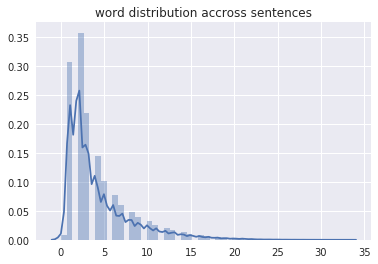

In [42]:
plt.title("word distribution accross sentences")
sns.distplot(word_id_len_train_sentences)
plt.show()

In [45]:
# we will consider two standard deviation as our seq len
seq_len = np.round((np.mean(word_id_len_train_sentences) + 2*np.std(word_id_len_train_sentences))).astype(int)
print seq_len

12


## Keras preprocessing and Model Building

In [46]:
from keras.preprocessing import sequence

#pad sequences if sentences greater than 12 we will cut off it
# smaller add 0s to it
word_id_train = sequence.pad_sequences(np.array(word_id_train_sentences), maxlen=seq_len)
word_id_test = sequence.pad_sequences(np.array(word_id_test_sentences), maxlen=seq_len)

Using TensorFlow backend.


In [47]:
y_train = train_df['Sentiment']

In [50]:
from keras.utils import np_utils

unique_labels = [0, 1, 2, 3, 4]
y_train_enc = np_utils.to_categorical(y_train, len(unique_labels))

In [51]:
print y_train_enc

[[ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 ..., 
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.]]


In [57]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, Embedding

model = Sequential()
model.add(Embedding(dictionary_size, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(unique_labels)))
model.add(Activation('softmax'))

In [58]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 128)         1761152   
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
_________________________________________________________________
activation_3 (Activation)    (None, 5)                 0         
Total params: 1,893,381
Trainable params: 1,893,381
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
model.fit(word_id_train, y_train_enc, nb_epoch=15, batch_size=256, verbose=1)

/usr/local/lib/python2.7/dist-packages/keras/models.py:834: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/15
156060/156060 [==============================] - 81s - loss: 0.9979 - acc: 0.5984    
Epoch 2/15
156060/156060 [==============================] - 84s - loss: 0.8200 - acc: 0.6628    
Epoch 3/15
156060/156060 [==============================] - 83s - loss: 0.7675 - acc: 0.6806    
Epoch 4/15
156060/156060 [==============================] - 79s - loss: 0.7257 - acc: 0.6955    
Epoch 5/15
156060/156060 [==============================] - 78s - loss: 0.6947 - acc: 0.7067    
Epoch 6/15
156060/156060 [==============================] - 81s - loss: 0.6690 - acc: 0.7154    
Epoch 7/15
156060/156060 [==============================] - 79s - loss: 0.6480 - acc: 0.7224    
Epoch 8/15
156060/156060 [==============================] - 81s - loss: 0.6300 - acc: 0.7291    
Epoch 9/15
156060/156060 [==============================] - 82s - loss: 0.6143 - acc: 0.7346    
Epoch 10/15
156060/156060 [==============================] - 84s - loss: 0.6004 - acc: 0.7383    
Epoch 11/15
156060/156060 [==

## Save Model

In [62]:
model.save("rotten_tomatoes_lstm_sentiment.h5")

In [63]:
test_pred = model.predict_classes(word_id_test)
test_df['Sentiment'] = test_pred.reshape(-1,1) 
header = ['PhraseId', 'Sentiment']
test_df.to_csv('./lstm_sentiment.csv', columns=header, index=False, header=True)

66144/66292 [============================>.] - ETA: 0s